In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Part 1: Data Collection
# Define tickers
stocks = ['META', 'MSFT', 'XOM', '^GSPC']  # ExxonMobil (XOM) as an oil sector stock

# Download data
start_date = '2012-01-01'
end_date = '2021-12-31'
data = yf.download(stocks, start=start_date, end=end_date)

# Inspect available columns
print("Available columns in downloaded data:", data.columns)

# Ensure we use the correct column name (try 'Close' if 'Adj Close' is missing)
if 'Adj Close' in data:
    data = data['Adj Close']
elif 'Close' in data:
    data = data['Close']
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' columns found in Yahoo Finance data!")

# Compute log returns
data = np.log(data / data.shift(1)).dropna()

# Add macroeconomic variables (Simulated for now)
np.random.seed(42)
data['Inflation'] = np.random.normal(0.02, 0.005, len(data))
data['Interest_Rates'] = np.random.normal(0.05, 0.01, len(data))
data['GDP_Growth'] = np.random.normal(0.03, 0.007, len(data))

# Download Oil Prices (CL=F for Crude Oil Futures)
oil_data = yf.download('CL=F', start=start_date, end=end_date)

if 'Adj Close' in oil_data:
    oil_prices = np.log(oil_data['Adj Close']).diff().dropna()
elif 'Close' in oil_data:
    oil_prices = np.log(oil_data['Close']).diff().dropna()
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' columns found for oil prices!")

data['Oil_Prices'] = oil_prices.reindex(data.index, method='ffill')  # Forward fill missing values

# Drop missing values
data = data.dropna()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


Available columns in downloaded data: MultiIndex([( 'Close',  'META'),
            ( 'Close',  'MSFT'),
            ( 'Close',   'XOM'),
            ( 'Close', '^GSPC'),
            (  'High',  'META'),
            (  'High',  'MSFT'),
            (  'High',   'XOM'),
            (  'High', '^GSPC'),
            (   'Low',  'META'),
            (   'Low',  'MSFT'),
            (   'Low',   'XOM'),
            (   'Low', '^GSPC'),
            (  'Open',  'META'),
            (  'Open',  'MSFT'),
            (  'Open',   'XOM'),
            (  'Open', '^GSPC'),
            ('Volume',  'META'),
            ('Volume',  'MSFT'),
            ('Volume',   'XOM'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [4]:
# Part 2: Data Statistics
print("Dataset Summary Statistics:\n", data.describe())

Dataset Summary Statistics:
 Ticker         META         MSFT          XOM        ^GSPC    Inflation  \
count   2420.000000  2420.000000  2420.000000  2420.000000  2420.000000   
mean       0.000908     0.001095     0.000043     0.000539     0.020161   
std        0.022940     0.016173     0.015843     0.010450     0.004928   
min       -0.210239    -0.159454    -0.130391    -0.127652     0.003794   
25%       -0.009524    -0.006137    -0.006799    -0.003171     0.016813   
50%        0.001050     0.000827    -0.000116     0.000702     0.020141   
75%        0.012299     0.008970     0.007183     0.005206     0.023378   
max        0.259371     0.132929     0.119442     0.089683     0.039264   

Ticker  Interest_Rates   GDP_Growth   Oil_Prices  
count      2420.000000  2420.000000  2420.000000  
mean          0.049754     0.029817     0.000097  
std           0.010030     0.007163     0.027795  
min           0.018233     0.007453    -0.282206  
25%           0.042918     0.024960    -

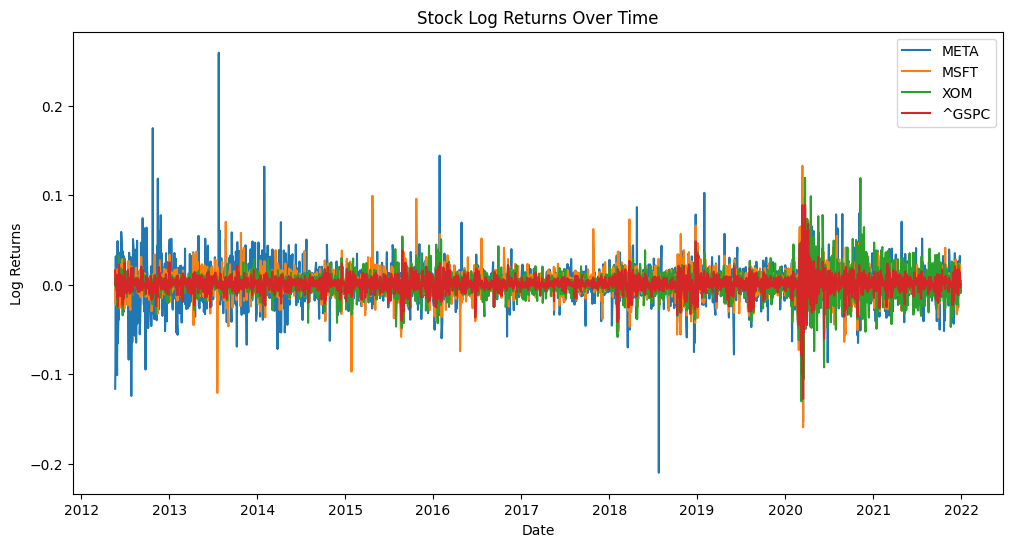

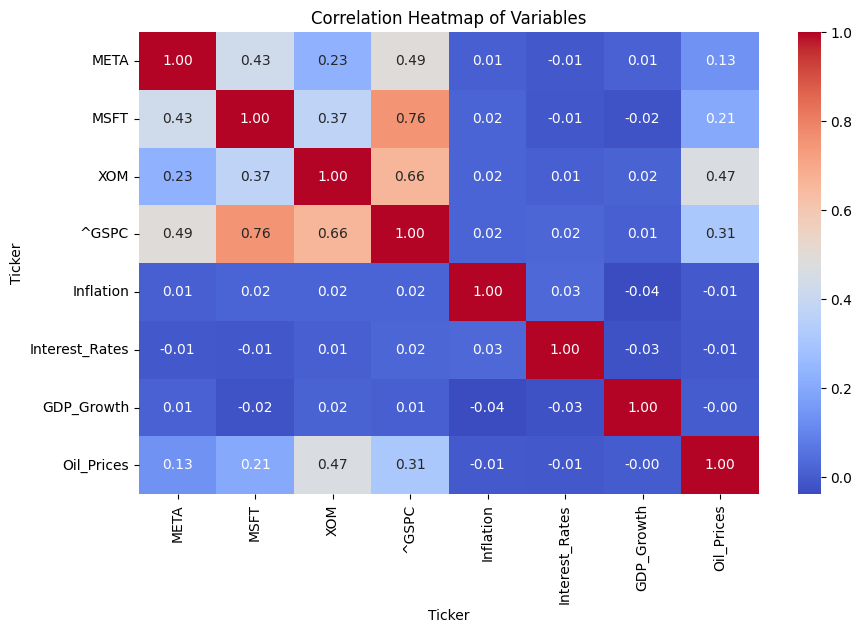

In [5]:
# Part 3: Data Visualization - Time series plot
plt.figure(figsize=(12,6))
for stock in ['META', 'MSFT', 'XOM', '^GSPC']:
    plt.plot(data.index, data[stock], label=stock)
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.title("Stock Log Returns Over Time")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap of Variables")
plt.show()

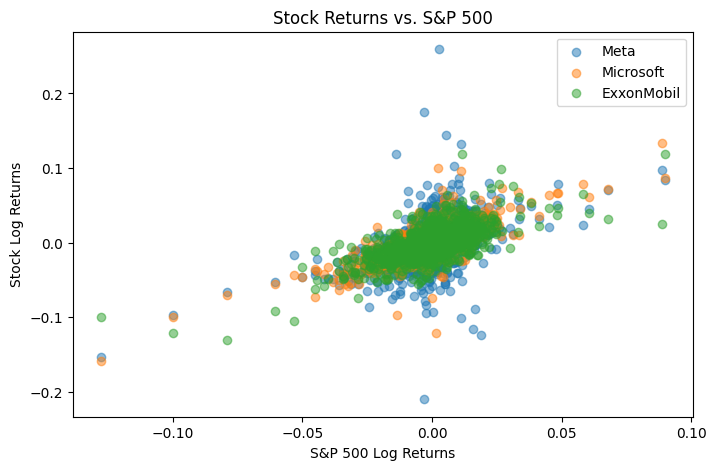

In [6]:
# Scatter Plot of Stock Returns vs. S&P 500
plt.figure(figsize=(8,5))
plt.scatter(data['^GSPC'], data['META'], alpha=0.5, label='Meta')
plt.scatter(data['^GSPC'], data['MSFT'], alpha=0.5, label='Microsoft')
plt.scatter(data['^GSPC'], data['XOM'], alpha=0.5, label='ExxonMobil')
plt.xlabel("S&P 500 Log Returns")
plt.ylabel("Stock Log Returns")
plt.legend()
plt.title("Stock Returns vs. S&P 500")
plt.show()

In [7]:
# Part 4: Multivariate Regression Model
X = data[['^GSPC', 'Inflation', 'Interest_Rates', 'GDP_Growth', 'Oil_Prices']]
y_meta = data['META']
y_msft = data['MSFT']
y_xom = data['XOM']
X = sm.add_constant(X)

# Fit regression models
meta_model = sm.OLS(y_meta, X).fit()
msft_model = sm.OLS(y_msft, X).fit()
xom_model = sm.OLS(y_xom, X).fit()

In [8]:
# Part 5: Print regression summaries
print("Meta Regression Summary:\n", meta_model.summary())
print("Microsoft Regression Summary:\n", msft_model.summary())
print("ExxonMobil Regression Summary:\n", xom_model.summary())

Meta Regression Summary:
                             OLS Regression Results                            
Dep. Variable:                   META   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     154.1
Date:                Mon, 17 Feb 2025   Prob (F-statistic):          2.15e-142
Time:                        07:35:56   Log-Likelihood:                 6037.1
No. Observations:                2420   AIC:                        -1.206e+04
Df Residuals:                    2414   BIC:                        -1.203e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             